# Data Pre-Processing and Analytics
This notebook demonstrates basic methods of data pre-processing and analytics. It also demonstrates how a simple common-sense checklist can greatly increase your odds of success if applied.

In [1]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import requests
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
load_dotenv()
api_key = os.getenv("fmp_api_key")
url_base = "https://financialmodelingprep.com/stable/"

constituents = requests.get(url=f"{url_base}sp500-constituent", params={"apikey": api_key}).json()
df_constituents = pd.DataFrame(constituents)
df_constituents = df_constituents[["symbol", "sector"]]
df_constituents = df_constituents.rename(columns={'symbol': 'ticker'})
df_constituents.to_csv("data/sp500_constituents.csv", index=False)

endpoints = [
    {"name": "income_statement","url": f"{url_base}income-statement","params": {"period": "annual", "limit": 100}},
    {"name": "balance_sheet","url": f"{url_base}balance-sheet-statement","params": {"period": "annual", "limit": 100}},
    {"name": "cashflow_statement","url": f"{url_base}cash-flow-statement","params": {"period": "annual", "limit": 100}},
    {"name": "financial_metrics","url": f"{url_base}key-metrics","params": {"period": "annual", "limit": 100}},
    {"name": "financial_ratios","url": f"{url_base}ratios","params": {"period": "annual", "limit": 100}},
    {"name": "income_statement_growth","url": f"{url_base}income-statement-growth","params": {"period": "annual", "limit": 100}},
    {"name": "balance_sheet_growth","url": f"{url_base}balance-sheet-statement-growth","params": {"period": "annual", "limit": 100}},
    {"name": "cashflow_statement_growth","url": f"{url_base}cash-flow-statement-growth","params": {"period": "annual", "limit": 100}},
    {"name": "dividend_adjusted_prices","url": f"{url_base}historical-price-eod/dividend-adjusted","params": {"from": "2000-01-01", "to": "2025-01-01"}}
]
dataset = {}
for ep in endpoints:
    temp = []
    for ticker in df_constituents["ticker"]:
        params = {**ep["params"], "symbol": ticker, "apikey": api_key}
        data = requests.get(url=ep["url"], params=params).json()
        if data:
            df_temp = pd.DataFrame(data)
            temp.append(df_temp)
    dataset[ep["name"]] = pd.concat(temp, ignore_index=True) if temp else pd.DataFrame()
    
for name, df in dataset.items():
    path = f"data/{name}.csv"
    df.to_csv(path, index=False)
for name, df in dataset.items():
    globals()[f"df_{name}"] = df

df_income_statement.head()

,date,symbol,reportedCurrency,cik,filingDate,acceptedDate,fiscalYear,period,revenue,costOfRevenue,...,netIncomeFromContinuingOperations,netIncomeFromDiscontinuedOperations,otherAdjustmentsToNetIncome,netIncome,netIncomeDeductions,bottomLineNetIncome,eps,epsDiluted,weightedAverageShsOut,weightedAverageShsOutDil
0,2024-12-31,IBKR,USD,0001381197,2025-03-05,2025-02-27 17:02:30,2024,FY,9316000000,1021000000,...,3407000000,0.0,0.0,755000000,0.0,755000000,1.7500,1.7300,432448000,436012000
1,2023-12-31,IBKR,USD,0001381197,2023-12-31,2023-12-30 19:00:00,2023,FY,7787000000,913000000,...,2812000000,0.0,0.0,600000000,0.0,600000000,1.4300,1.4175,419860000,423388000
2,2022-12-31,IBKR,USD,0001381197,2023-02-24,2023-02-24 16:05:50,2022,FY,4192000000,778000000,...,1842000000,0.0,0.0,380000000,0.0,380000000,0.9450,0.9375,401840000,405200000
3,2021-12-31,IBKR,USD,0001381197,2022-02-25,2022-02-25 17:24:08,2021,FY,2940000000,635000000,...,1636000000,0.0,0.0,308000000,0.0,308000000,0.8175,0.8100,376672000,380040000
4,2020-12-31,IBKR,USD,0001381197,2021-03-01,2021-03-01 06:23:58,2020,FY,2420000000,618000000,...,1179000000,0.0,0.0,195000000,0.0,195000000,0.6100,0.6050,319756000,322556000


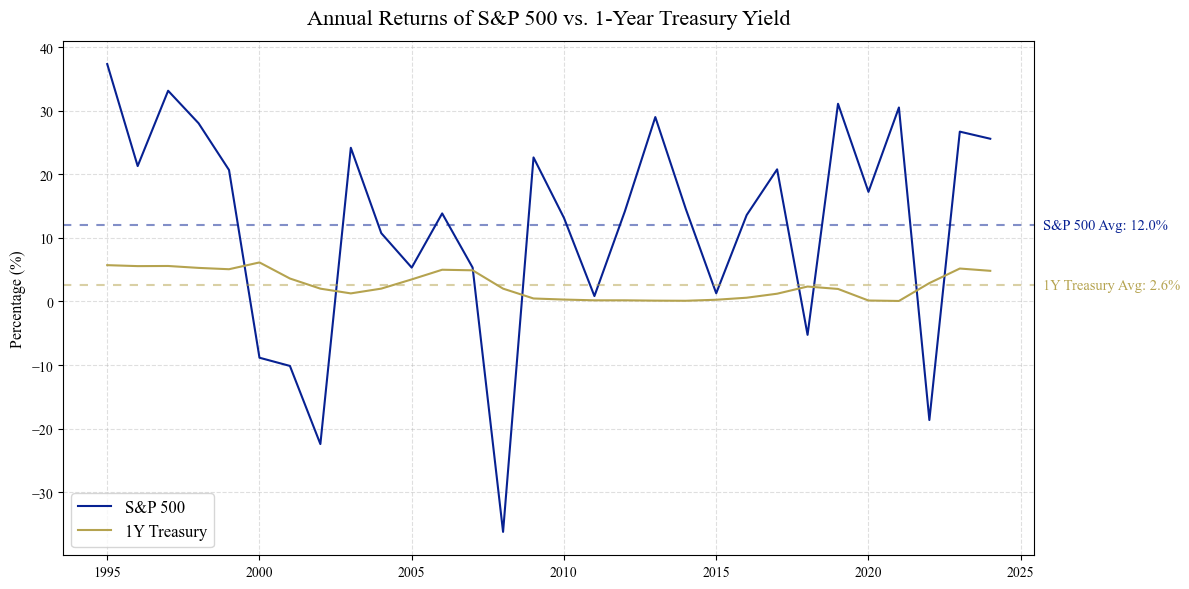

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

index_data = requests.get(url=f"{url_base}historical-price-eod/dividend-adjusted", params={"from": "1995-01-01", "to": "2025-01-01", "symbol": "SPY", "apikey": api_key}).json()
df_index = pd.DataFrame(index_data)
df_index["date"] = pd.to_datetime(df_index["date"])
df_index["year"] = df_index["date"].dt.year
df_index["total_return_pct"] = ((df_index["adjClose"] / df_index["adjClose"].iloc[-1]) - 1) * 100
df_index.to_csv("data/index_data.csv", index=False)
df_index_1yr_returns = (
    df_index
    .sort_values("date")
    .groupby("year")["adjClose"]
    .agg(first="first", last="last")
    .eval("pct_return = (last / first - 1) * 100")[["pct_return"]]
    .reset_index()
)
df_index_1yr_returns.to_csv("data/index_1yr_returns.csv", index=False)

treasury_rates = requests.get(url=f"{url_base}treasury-rates", params={"from": "1995-01-01", "to": "2025-01-01", "apikey": api_key}).json()
df_treasury = pd.DataFrame(treasury_rates)
df_treasury["date"] = pd.to_datetime(df_treasury["date"])
df_treasury["year"] = df_treasury["date"].dt.year
df_1yr_treasury = df_treasury[["year", "year1"]]
df_1yr_treasury_median = (df_1yr_treasury.groupby("year", as_index=False).median(numeric_only=True).rename(columns={"year1": "1yr_yield"}))

avg_sp_return = df_index_1yr_returns["pct_return"].mean()
avg_treasury_yield = df_1yr_treasury_median["1yr_yield"].mean()

mpl.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_index_1yr_returns, x="year", y="pct_return",color="#072192", label="S&P 500")
sns.lineplot(data=df_1yr_treasury_median, x="year", y="1yr_yield",color="#b5a34f", label="1Y Treasury")
plt.title("Annual Returns of S&P 500 vs. 1-Year Treasury Yield", fontsize=16, pad=12)
plt.xlabel("")
plt.ylabel("Percentage (%)", fontsize=11.5)
plt.legend(fontsize=12, loc="lower left")
plt.grid(True, linestyle="--", alpha=0.4)
ax = plt.gca()
ax.axhline(avg_sp_return, linestyle=(0, (4, 4)), color="#072192", alpha=0.5)
ax.axhline(avg_treasury_yield, linestyle=(0, (4, 4)), color="#b5a34f", alpha=0.51)
xmax = ax.get_xlim()[1]
for y, color, label in [(avg_sp_return, "#072192", "S&P 500 Avg"),(avg_treasury_yield, "#b5a34f", "1Y Treasury Avg")]:
    ax.annotate(
        f"{label}: {y:.1f}%",
        xy=(xmax, y), xycoords=("data", "data"),
        xytext=(6, 0), textcoords="offset points",
        ha="left", va="center", fontsize=10.5, color=color)
plt.tight_layout()
plt.show()

>*A volatile 12% is better than a stable 3%, given that you have the ability to react with equanimity to normal vicissitudes and worldly outcomes. This, however, does not mean that the index is guaranteed to produce such results indefinitely.*

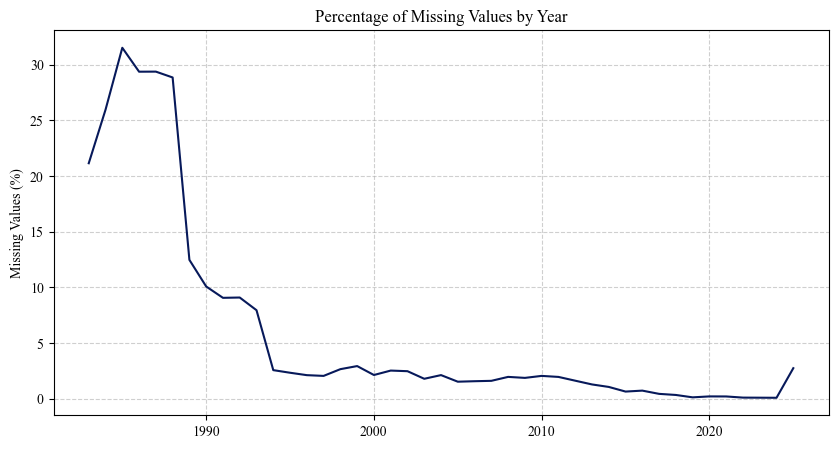

In [3]:
for name, df in dataset.items():
    if "reportedCurrency" in df.columns:
        dataset[name] = df[df["reportedCurrency"] == "USD"]

def sel_rename(df, mapping):
    return df.rename(columns=mapping)[list(mapping.values())]
    
map_income = {
    "symbol":"ticker","fiscalYear":"year","revenue":"revenue","grossProfit":"gross_profit","operatingIncome":"operating_income","netIncome":"net_income",
    "eps":"eps", "epsDiluted":"eps_diluted","weightedAverageShsOut":"shares_outstanding","weightedAverageShsOutDil":"shares_outstanding_diluted"
}
map_income_g = {
    "symbol":"ticker","fiscalYear":"year","growthRevenue":"revenue_growth","growthGrossProfit":"gross_profit_growth",
    "growthOperatingIncome":"operating_income_growth","growthNetIncome":"net_income_growth","growthEPSDiluted":"eps_diluted_growth"
}
map_balance = {
    "symbol":"ticker","fiscalYear":"year","cashAndCashEquivalents":"cash_and_equivalents","totalCurrentAssets":"current_assets",
    "propertyPlantEquipmentNet":"ppe","totalNonCurrentAssets":"non_current_assets","totalAssets":"total_assets",
    "totalCurrentLiabilities":"current_liabilities","longTermDebt":"long_term_debt","totalNonCurrentLiabilities":"non_current_liabilities",
    "totalLiabilities":"total_liabilities","retainedEarnings":"retained_earnings","totalStockholdersEquity":"stockholders_equity","totalEquity":"total_equity",
}
map_balance_g = {
    "symbol":"ticker","fiscalYear":"year","growthCashAndCashEquivalents":"cash_and_equivalents_growth","growthTotalCurrentAssets":"current_assets_growth",
    "growthPropertyPlantEquipmentNet":"ppe_growth","growthTotalNonCurrentAssets":"non_current_assets_growth","growthTotalAssets":"total_assets_growth",
    "growthTotalCurrentLiabilities":"current_liabilities_growth","growthLongTermDebt":"long_term_debt_growth","growthTotalNonCurrentLiabilities":"non_current_liabilities_growth",
    "growthTotalLiabilities":"total_liabilities_growth","growthRetainedEarnings":"retained_earnings_growth","growthTotalStockholdersEquity":"stockholders_equity_growth","growthTotalEquity":"total_equity_growth",
}
map_cf = {
    "symbol":"ticker","fiscalYear":"year","depreciationAndAmortization":"depreciation_amortization","netChangeInCash":"net_change_cash",
    "operatingCashFlow":"operating_cashflow","capitalExpenditure":"capex","freeCashFlow":"free_cashflow"
}
map_cf_g = {
    "symbol":"ticker","fiscalYear":"year","growthDepreciationAndAmortization":"depreciation_amortization_growth","growthNetChangeInCash":"net_change_cash_growth",
    "growthOperatingCashFlow":"operating_cashflow_growth","growthCapitalExpenditure":"capex_growth","growthFreeCashFlow":"free_cashflow_growth",
}
map_metrics = {"symbol":"ticker","fiscalYear":"year","marketCap":"market_cap"}
map_ratios = {"symbol":"ticker","fiscalYear":"year","priceToEarningsRatio":"pe","priceToBookRatio":"pb","bookValuePerShare":"book_value_per_share"}
df_income_statement = sel_rename(df_income_statement, map_income)
df_income_statement_growth = sel_rename(df_income_statement_growth, map_income_g)
df_balance_sheet = sel_rename(df_balance_sheet, map_balance)
df_balance_sheet_growth = sel_rename(df_balance_sheet_growth, map_balance_g)
df_cashflow_statement = sel_rename(df_cashflow_statement, map_cf)
df_cashflow_statement_growth = sel_rename(df_cashflow_statement_growth, map_cf_g)
df_financial_metrics = sel_rename(df_financial_metrics, map_metrics)
df_financial_ratios = sel_rename(df_financial_ratios, map_ratios)

df_stock_returns = (
    df_dividend_adjusted_prices
      .assign(date=lambda d: pd.to_datetime(d["date"]))
      .rename(columns={"symbol": "ticker"})
      .assign(year=lambda d: d["date"].dt.year.astype("string"))
      .sort_values(["ticker","date"])
      .groupby(["ticker","year"], as_index=False)
      .agg(first=("adjClose","first"), last=("adjClose","last"))
      .assign(pct_return=lambda x: (x["last"]/x["first"] - 1)*100)
      [["ticker","year","pct_return"]]
)
df_stock_returns.to_csv("data/stock_returns.csv", index=False)

df_stock_returns["year"] = df_stock_returns["year"].astype("string")
df_merged = df_stock_returns.copy()
for df in [df_income_statement, df_income_statement_growth, df_balance_sheet,
           df_balance_sheet_growth, df_cashflow_statement, df_cashflow_statement_growth, df_financial_metrics, df_financial_ratios]:
    df_merged = pd.merge(df_merged, df, on=["ticker", "year"], how="outer")
df_merged["year"] = pd.to_numeric(df_merged["year"]).astype("Int64")

for col in [c for c in df_merged.columns if c.endswith("_growth")]:
    df_merged[col] = df_merged[col] * 100

n_cols = df_merged.shape[1] - 2
df_merged["missing_pct_row"] = (df_merged.drop(columns=["ticker","year"]).isna().sum(axis=1) / n_cols)
missing_pct_year = (df_merged.groupby("year")["missing_pct_row"].mean().reset_index(name="avg_missing_pct"))

plt.figure(figsize=(10,5))
plt.plot(missing_pct_year["year"], missing_pct_year["avg_missing_pct"]*100, color="#07195a")
plt.title("Percentage of Missing Values by Year")
plt.xlabel("")
plt.ylabel("Missing Values (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

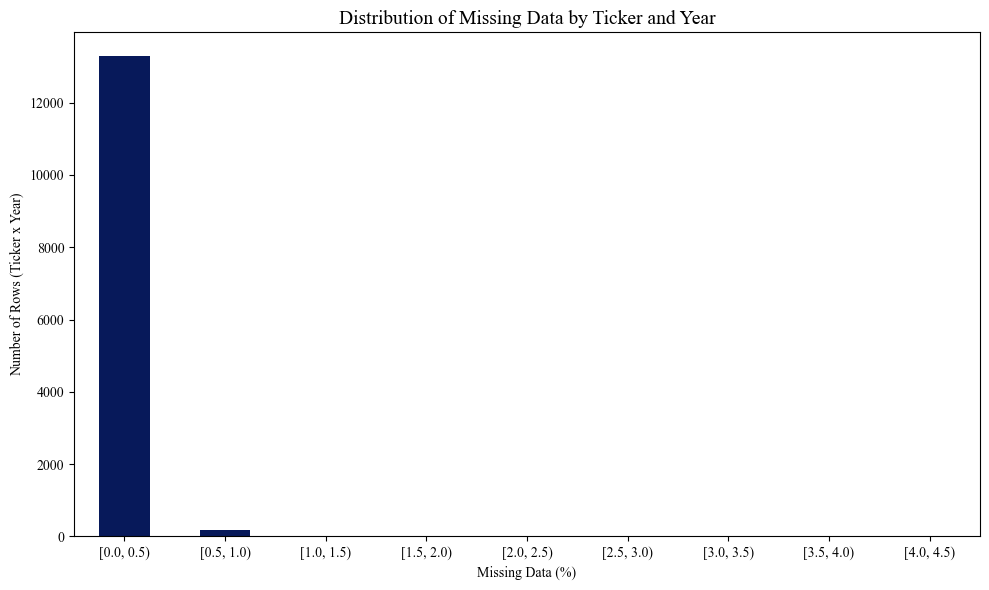

In [4]:
df_merged = df_merged[df_merged["year"] >= 1995]

missing_pct_bins = np.arange(0, 5, 0.5)
missing_pct_counts = (pd.cut(df_merged["missing_pct_row"], bins=missing_pct_bins, right=False).value_counts().sort_index())

plt.figure(figsize=(10,6))
missing_pct_counts.plot(kind="bar", color="#07195a")
plt.title("Distribution of Missing Data by Ticker and Year", fontsize=14)
plt.xlabel("Missing Data (%)")
plt.ylabel("Number of Rows (Ticker x Year)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [5]:
df_merged = df_merged[df_merged["missing_pct_row"] <= 1]
missing_pct_by_col = (df_merged.isna().mean().sort_values(ascending=False) * 100)
missing_pct_by_col.head()

pct_return                   17.246765
free_cashflow_growth          1.375874
capex_growth                  1.375874
operating_cashflow_growth     1.375874
net_change_cash_growth        1.375874
dtype: float64

In [6]:
missing_pct_return_by_year = (df_merged.groupby("year")["pct_return"].apply(lambda x: x.isna().mean() * 100).reset_index(name="missing_pct"))
missing_pct_return_by_year.head(10)

,year,missing_pct
0,1995,100.000000
1,1996,100.000000
2,1997,100.000000
3,1998,100.000000
4,1999,100.000000
5,2000,10.224439
6,2001,9.903382
7,2002,10.000000
8,2003,10.141509
9,2004,8.196721


In [7]:
df_merged = df_merged[(df_merged["year"] >= 2000) & (df_merged["year"] <= 2024)]
df_merged = df_merged[df_merged["missing_pct_row"] <= 1]
missing_pct_by_col = (df_merged.isna().mean().sort_values(ascending=False) * 100)
missing_pct_by_col.head()

pct_return                   4.497468
free_cashflow_growth         1.407604
capex_growth                 1.407604
operating_cashflow_growth    1.407604
net_change_cash_growth       1.407604
dtype: float64

In [8]:
df_merged = df_merged.dropna(subset=["pct_return"])

df_merged = df_merged.sort_values(["ticker","year"])
for g in [c for c in df_merged.columns if c.endswith("_growth")]:
    base = g[:-7]
    prev = df_merged.groupby("ticker")[base].shift(1)
    calc = (df_merged[base] / prev) - 1
    mask = df_merged[g].isna() & prev.notna() & (prev != 0) & df_merged[base].notna()
    df_merged.loc[mask, g] = calc[mask]
mask = df_merged["book_value_per_share"].isna() & df_merged["stockholders_equity"].notna() & df_merged["shares_outstanding"].notna()
df_merged.loc[mask, "book_value_per_share"] = (df_merged.loc[mask, "stockholders_equity"] / df_merged.loc[mask, "shares_outstanding"])

df_merged = df_merged[df_merged["missing_pct_row"] <= 1]
missing_pct_by_col = (df_merged.isna().mean().sort_values(ascending=False) * 100)
missing_pct_by_col.head()

market_cap                     0.889728
pe                             0.889728
pb                             0.889728
current_liabilities_growth     0.718972
cash_and_equivalents_growth    0.718972
dtype: float64

In [9]:
df_merged["missing_subset"] = (df_merged.drop(columns=["ticker", "year"]).isna().sum(axis=1))
df_merged["missing_subset"].value_counts().sort_index()

missing_subset
0     11025
3        22
25        4
51       76
Name: count, dtype: int64

In [10]:
df_merged = df_merged[df_merged["missing_subset"] < 25].copy()
df_merged.loc[df_merged["missing_subset"] >= 3, ["ticker","year"]]

,ticker,year
13362,STX,2003
13363,STX,2004
13364,STX,2005
13365,STX,2006
13366,STX,2007
13367,STX,2008
13368,STX,2009
13369,STX,2010
13370,STX,2011
13371,STX,2012


In [11]:
df_merged = df_merged[df_merged["missing_subset"] == 0].copy()
df_merged.isna().any().any()

np.False_

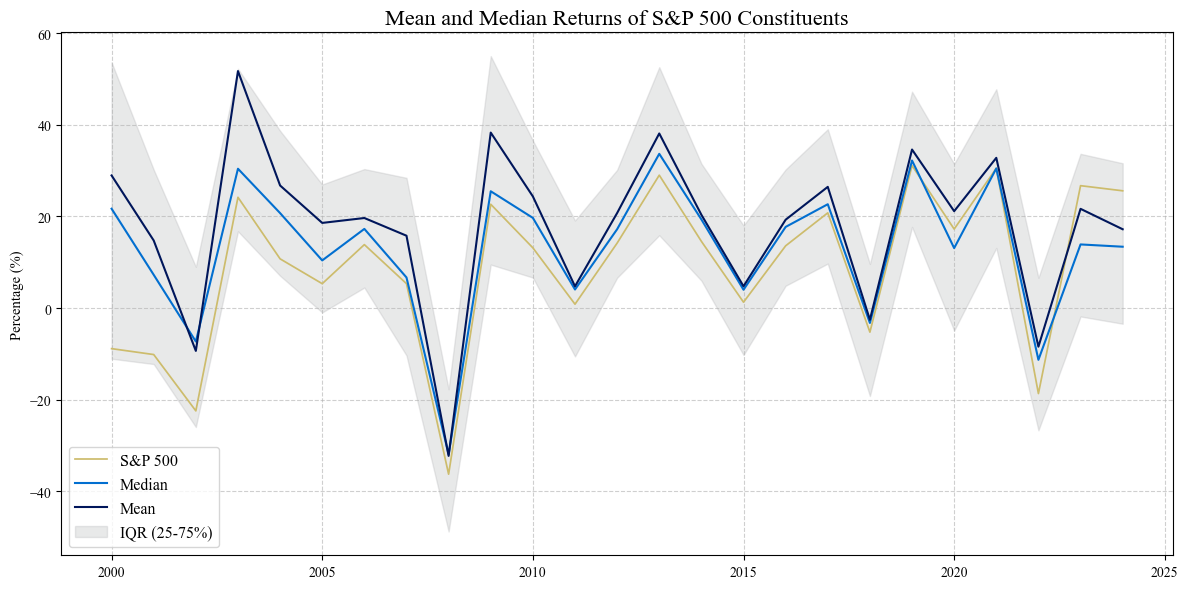

In [12]:
df_merged.to_csv("data/merged_financial_data.csv", index=False)

df_2000 = df_merged[df_merged["year"] >= 2000].copy()
df_2000_return = df_2000.groupby("year")["pct_return"]
pct_return_stats = (
    df_2000_return.quantile([0.25, 0.5, 0.75])
    .unstack()
    .rename(columns={0.25: "q25", 0.5: "median", 0.75: "q75"})
    .reset_index()
    .sort_values("year")
)
pct_return_stats["mean"] = df_2000_return.mean().reindex(pct_return_stats["year"]).to_numpy()

df_index_1yr_returns_2000 = (df_index_1yr_returns[df_index_1yr_returns["year"] >= 2000].sort_values("year"))

plt.figure(figsize=(12,6))
plt.plot(df_index_1yr_returns_2000["year"], df_index_1yr_returns_2000["pct_return"], linewidth=1.25, label="S&P 500", color="#cdbc6c")
plt.plot(pct_return_stats["year"], pct_return_stats["median"], label="Median", color="#026fd0")
plt.plot(pct_return_stats["year"], pct_return_stats["mean"], label="Mean", color="#00165b")
plt.fill_between(pct_return_stats["year"], pct_return_stats["q25"], pct_return_stats["q75"], alpha=0.25, label="IQR (25-75%)", color="#a7a8aa")
plt.title("Mean and Median Returns of S&P 500 Constituents", fontsize=16)
plt.ylabel("Percentage (%)", fontsize=10.5)
plt.legend(fontsize=11.5, loc="lower left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

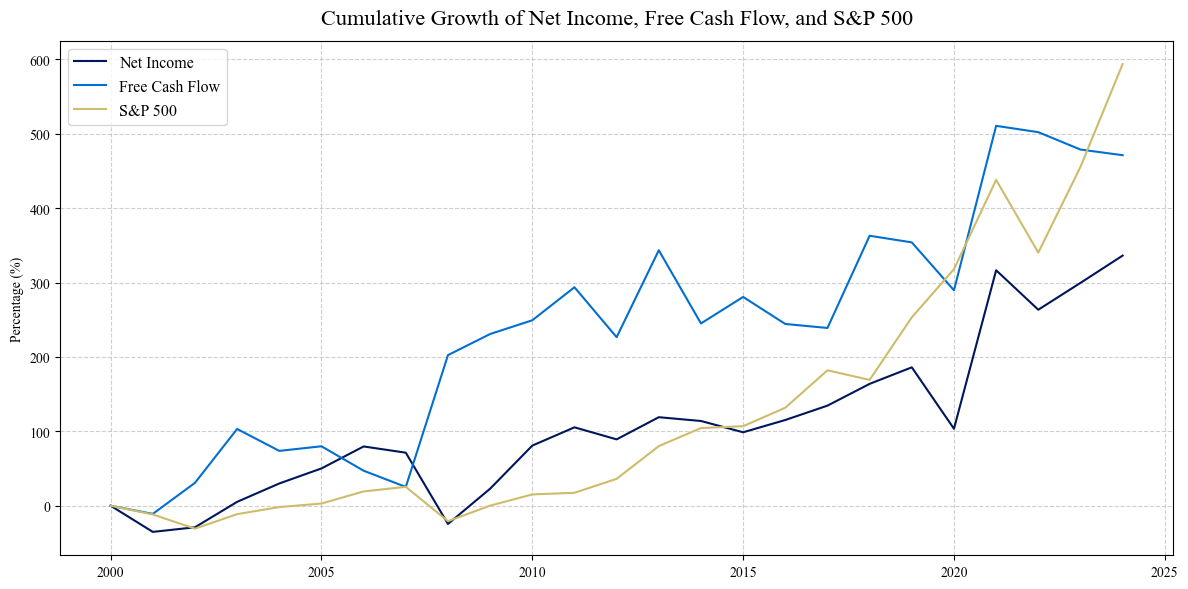

In [13]:
agg = (df_merged[df_merged["year"] >= 2000].groupby("year")[["net_income", "free_cashflow"]].mean().sort_index())

def cum_pct(s, base_year=2000):
    return (s / s.loc[base_year] - 1) * 100
cum_df = agg[["net_income", "free_cashflow"]].apply(cum_pct)

index_cum = (df_index[df_index["year"] >= 2000].sort_values("date").groupby("year")["adjClose"].last().pipe(lambda s: (s / s.loc[2000] - 1) * 100))
cum_df = cum_df.join(index_cum.rename("S&P 500 Total Return"), how="inner")
plot_df = cum_df.reset_index()

plt.figure(figsize=(12,6))
plt.plot(plot_df["year"], plot_df["net_income"], label="Net Income", color="#00165b")
plt.plot(plot_df["year"], plot_df["free_cashflow"], label="Free Cash Flow", color="#026fd0")
plt.plot(plot_df["year"], plot_df["S&P 500 Total Return"], label="S&P 500", color="#cdbc6c")
plt.title("Cumulative Growth of Net Income, Free Cash Flow, and S&P 500", fontsize=16, pad=12)
plt.xlabel("")
plt.ylabel("Percentage (%)")
plt.legend(fontsize=11.5)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

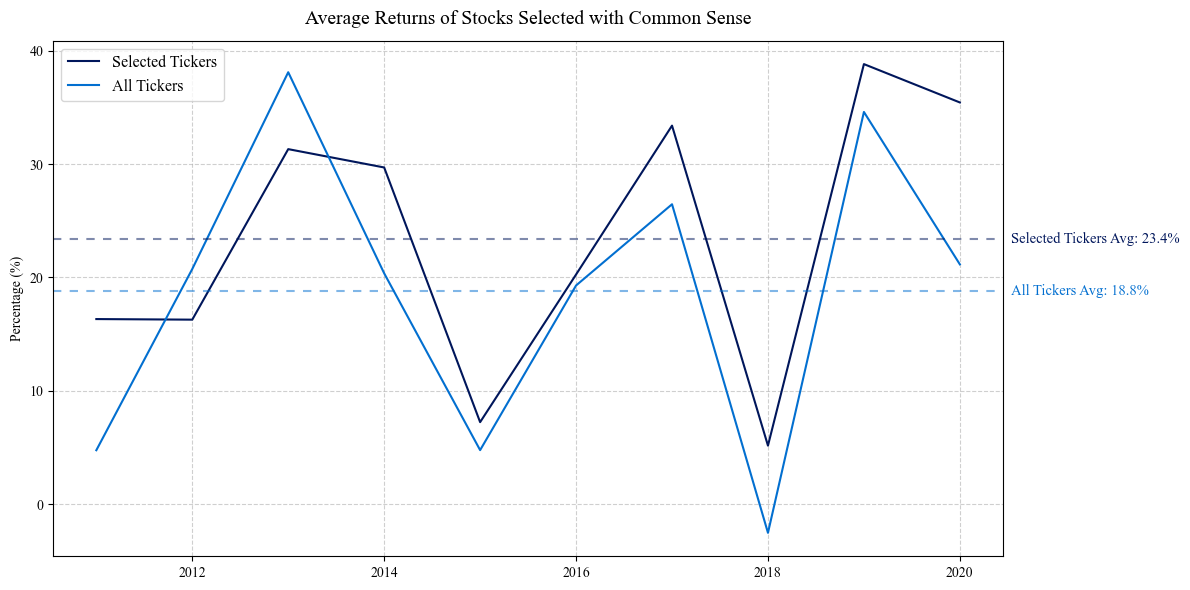

In [14]:
df_returns = df_merged[["ticker", "year", "pct_return"]]

checklist = (
    df_merged.query("2001 <= year <= 2010")
    .groupby("ticker")[["cash_and_equivalents","long_term_debt","net_income_growth","free_cashflow_growth","revenue_growth","pe"]]
    .mean()
)
common_sense_checklist = checklist[
    (checklist["cash_and_equivalents"] > checklist["long_term_debt"]) &
    (checklist["net_income_growth"] > 15) &
    (checklist["free_cashflow_growth"] > 15) &
    (checklist["revenue_growth"] > 15) &
    (checklist["pe"] < 50)
].index

df_mean_all = df_returns.query("2011 <= year <= 2020").groupby("year")["pct_return"].mean()
df_common_sense = df_returns.query("2011 <= year <= 2020 and ticker in @common_sense_checklist").groupby("year")["pct_return"].mean()
avg_common_sense = df_common_sense.mean()
avg_all = df_mean_all.mean()

plt.figure(figsize=(12, 6))
plt.plot(df_common_sense.index, df_common_sense.values, label="Selected Tickers", color="#00165b")
plt.plot(df_mean_all.index, df_mean_all.values, label="All Tickers", color="#026fd0")
plt.xlabel("")
plt.ylabel("Percentage (%)")
plt.title("Average Returns of Stocks Selected with Common Sense", fontsize=14, pad=12)
plt.legend(fontsize=11.5)
plt.grid(True, linestyle="--", alpha=0.6)
ax = plt.gca()
ax.axhline(avg_common_sense, linestyle=(0, (4, 4)), color="#00165b", alpha=0.5)
ax.axhline(avg_all, linestyle=(0, (4, 4)), color="#026fd0", alpha=0.5)
xmax = ax.get_xlim()[1]
for y, color, label in [(avg_common_sense, "#00165b", "Selected Tickers Avg"), (avg_all, "#026fd0", "All Tickers Avg")]:
    ax.annotate(
        f"{label}: {y:.1f}%",
        xy=(xmax, y), xycoords=("data", "data"),
        xytext=(6, 0), textcoords="offset points",
        ha="left", va="center", fontsize=10.5, color=color)
plt.tight_layout()
plt.show()

> Stocks were selected with a common-sense checklist: (1) cash and cash equivalents exceed long term debt; (2) net income, free cash flow, and revenue are each growing at 15+%; and (3) PE is below 50. The criteria were applied to the average metrics of each ticker from 2001-2010. Returns were then plotted for 2011-2020.<br>
> ***A simple common-sense checklist can greatly increase your odds of success if applied.***